In [2]:
from bulid_transformer_model import bulid_model
from data_loading import load_data
from sequence_generator import seq_generator
from experiment_filter import filter

2023-11-01 15:48:26.004800: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 15:48:26.043834: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 15:48:26.044348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 15:48:26.824384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
experiments = filter('VISp',0.3)
#(train_movie,train_trace,train_speed),_ = load_data(501271265)

In [4]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc = BrainObservatoryCache(cache= True,manifest_file='../brain_data/brain_observatory_manifest.json')


In [19]:
boc.get_ophys_experiments(ids = [652094901])

[{'id': 652094901,
  'imaging_depth': 175,
  'targeted_structure': 'VISp',
  'cre_line': 'Slc17a7-IRES2-Cre',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 87,
  'experiment_container_id': 650389885,
  'session_type': 'three_session_A',
  'donor_name': '355468',
  'specimen_name': 'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355468',
  'fail_eye_tracking': False}]

In [5]:
nwb = boc.get_ophys_experiment_data(ophys_experiment_id=experiments[0])
#x = nwb.get_pupil_location()
x = boc.get_eye_tracking(ophys_experiment_id=652094901)

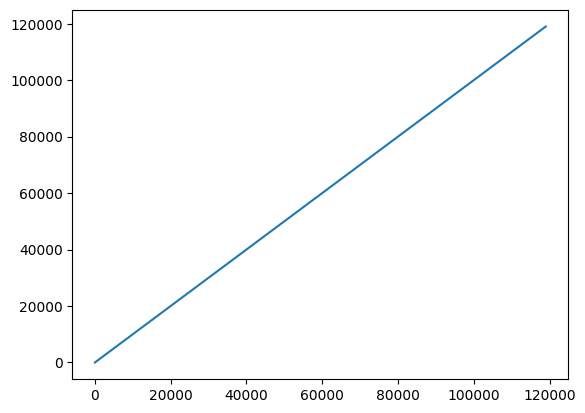

In [6]:
from matplotlib import pyplot as plt
plt.plot(x[:,0])

In [5]:
boc.get_ophys_experiments(ids=[experiments[0]])

[{'id': 652094901,
  'imaging_depth': 175,
  'targeted_structure': 'VISp',
  'cre_line': 'Slc17a7-IRES2-Cre',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 87,
  'experiment_container_id': 650389885,
  'session_type': 'three_session_A',
  'donor_name': '355468',
  'specimen_name': 'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-355468',
  'fail_eye_tracking': False}]

In [3]:
model = bulid_model(num_heads=4,spatial_layers=3,temporal_layers=2,delay=40,embed_dim=128,output_shape=8)

data = seq_generator(x = train_movie,y = train_trace,r = train_speed,delay = 40,shuffle=True,batch_size=10)
